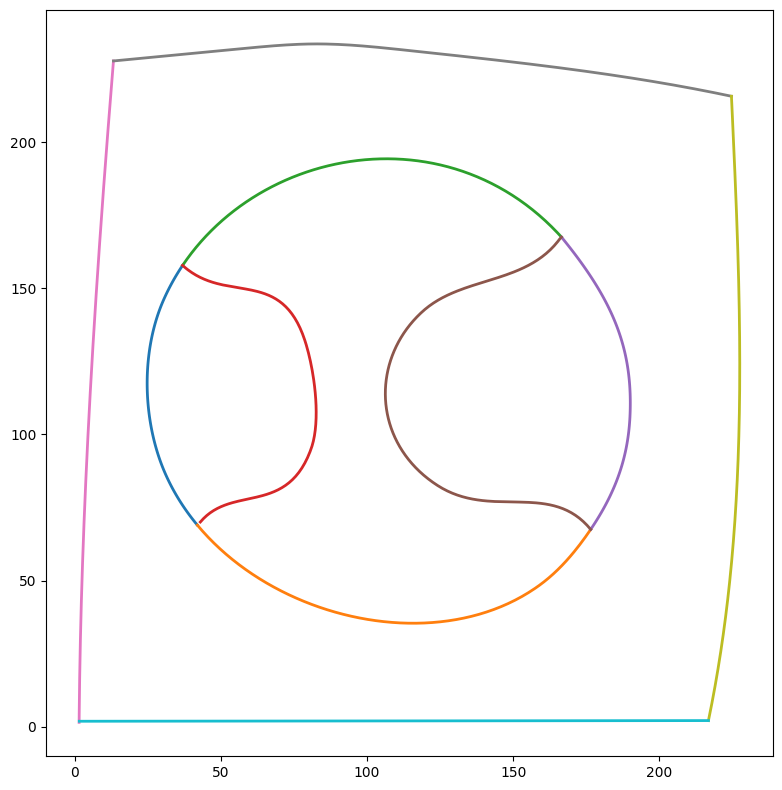

In [17]:
import numpy as np
import matplotlib.pyplot as plt


def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs


def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect("equal")
    plt.show()


# Example usage
csv_path = "./frag0.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)
plot(paths_XYs)

In [18]:
from sklearn.linear_model import LinearRegression
import numpy as np


def is_straight_line(XY, threshold=1e-1):  # Increased default threshold
    X = XY[:, 0].reshape(-1, 1)
    y = XY[:, 1]

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    residuals = y - y_pred
    variance = np.var(residuals)

    return variance < threshold, model


# Example usage
for path in paths_XYs:
    for XY in path:
        is_line, model = is_straight_line(XY)
        if is_line:
            print("Detected a straight line with slope:", model.coef_[0])

Detected a straight line with slope: 0.001073341490665822


In [19]:
def fit_circle(XY):
    # Calculate the centroid of the points
    x_m = np.mean(XY[:, 0])
    y_m = np.mean(XY[:, 1])
    
    # Function to calculate the algebraic distance between the points and the circle
    def calc_R(xc, yc):
        return np.sqrt((XY[:, 0] - xc)**2 + (XY[:, 1] - yc)**2)
    
    def f(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    from scipy.optimize import least_squares
    center_estimate = x_m, y_m
    result = least_squares(f, center_estimate)
    xc, yc = result.x
    Ri = calc_R(xc, yc)
    R = Ri.mean()
    residuals = Ri - R

    return (xc, yc), R, np.var(residuals)

def is_circle(XY):
    center, radius, variance = fit_circle(XY)
    return variance < 1e-2, center, radius

# Example usage
for path in paths_XYs:
    for XY in path:
        is_circ, center, radius = is_circle(XY)
        if is_circ:
            print(f"Detected a circle with center: {center} and radius: {radius}")


Detected a circle with center: (np.float64(100.26763346691945), np.float64(116.97769870078963)) and radius: 75.5894056387733
Detected a circle with center: (np.float64(3133.1639826461133), np.float64(-52.141078678577074)) and radius: 3132.287368047773
Detected a circle with center: (np.float64(1232.2769728874941), np.float64(-1046337.9654925676)) and radius: 1046340.5616071566


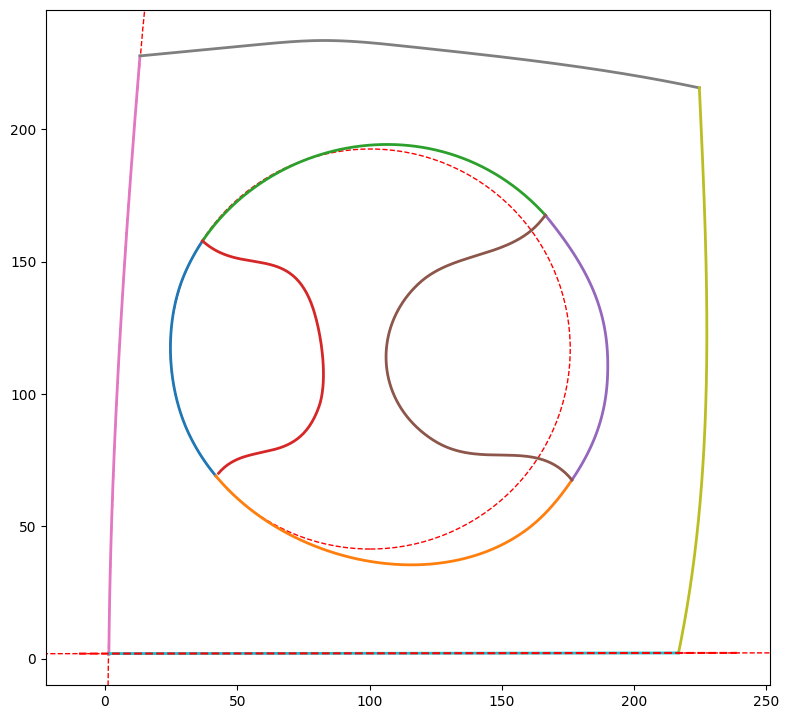

In [20]:
def plot_detected_shapes(paths_XYs, detected_shapes):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)

    for shape in detected_shapes:
        if shape['type'] == 'line':
            model = shape['model']
            x_vals = np.array(ax.get_xlim())
            y_vals = model.coef_[0] * x_vals + model.intercept_
            ax.plot(x_vals, y_vals, '--', color='red')
        elif shape['type'] == 'circle':
            center, radius = shape['center'], shape['radius']
            circle = plt.Circle(center, radius, color='red', fill=False, linestyle='--')
            ax.add_artist(circle)

    ax.set_aspect('equal')
    plt.show()

# Example usage
detected_shapes = []
for path in paths_XYs:
    for XY in path:
        is_line, model = is_straight_line(XY)
        if is_line:
            detected_shapes.append({'type': 'line', 'model': model})

        is_circ, center, radius = is_circle(XY)
        if is_circ:
            detected_shapes.append({'type': 'circle', 'center': center, 'radius': radius})

plot_detected_shapes(paths_XYs, detected_shapes)

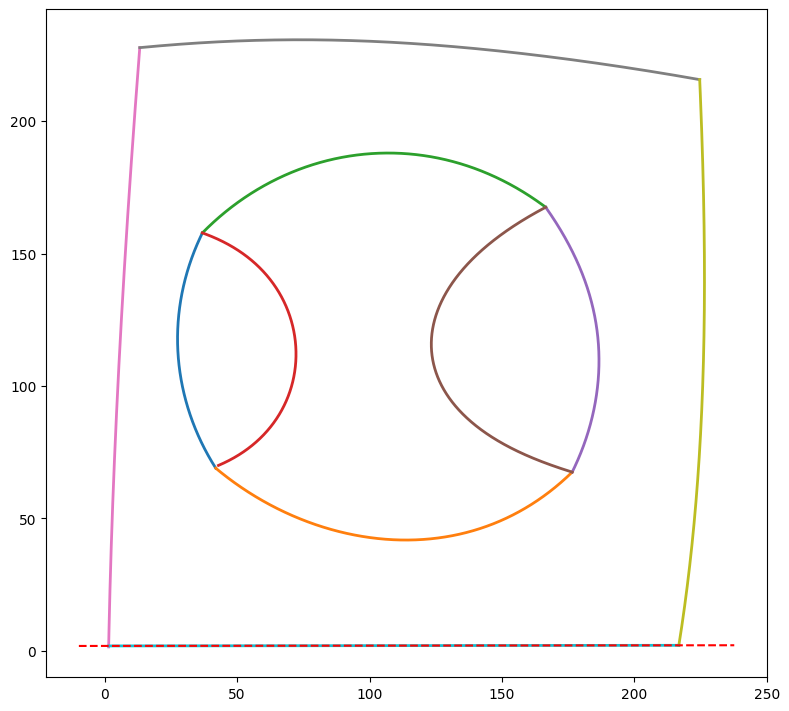

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import bezier
from sklearn.linear_model import LinearRegression

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def normalize_with_bezier(XY, num_points=100000, degree=10000):
    if XY.shape[0] < degree + 1:
        raise ValueError(f"Input data must have at least {degree + 1} points to create a degree {degree} Bezier curve.")
    
    # Select nodes for the Bezier curve
    indices = np.linspace(0, len(XY) - 1, degree + 1, dtype=int)
    selected_nodes = XY[indices]
    
    nodes = np.asfortranarray(selected_nodes.T)
    curve = bezier.Curve(nodes, degree=degree)
    s_vals = np.linspace(0.0, 1.0, num_points)
    normalized_XY = curve.evaluate_multi(s_vals).T
    return normalized_XY

def is_straight_line(XY, threshold=1e-1):
    X = XY[:, 0].reshape(-1, 1)
    y = XY[:, 1]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    residuals = y - y_pred
    variance = np.var(residuals)
    return variance < threshold, model

# Example usage
csv_path = "./frag0.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)

# Normalize curves with higher degree Bezier
normalized_paths_XYs = []
for path in paths_XYs:
    normalized_path = [normalize_with_bezier(XY, degree=5) for XY in path]
    normalized_paths_XYs.append(normalized_path)

# Detect shapes
detected_shapes = []
for path in normalized_paths_XYs:
    for XY in path:
        is_line, model = is_straight_line(XY)
        if is_line:
            detected_shapes.append({'type': 'line', 'model': model})

# Plot detected shapes
plot_detected_shapes(normalized_paths_XYs, detected_shapes)